In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.cluster.hierarchy import linkage, dendrogram

In [106]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor

In [107]:
concrete = pd.read_csv('data/concrete/concrete.csv', index_col=0)
mixtures = pd.read_csv('data/concrete/mixtures.csv', index_col=0)

In [8]:
concrete.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
1,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
2,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
4,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
5,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [9]:
mixtures.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
1,0.223094,0.00000,0.0,0.066928,0.001033,0.429663,0.279281,28,79.99
2,0.221720,0.00000,0.0,0.066516,0.001026,0.433176,0.277561,28,61.89
3,0.149170,0.06393,0.0,0.102288,0.000000,0.418125,0.266487,270,40.27
4,0.149170,0.06393,0.0,0.102288,0.000000,0.418125,0.266487,365,41.05
5,0.085350,0.05690,0.0,0.082513,0.000000,0.420474,0.354764,360,44.30


In [10]:
concrete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030 entries, 1 to 1030
Data columns (total 9 columns):
Cement                 1030 non-null float64
BlastFurnaceSlag       1030 non-null float64
FlyAsh                 1030 non-null float64
Water                  1030 non-null float64
Superplasticizer       1030 non-null float64
CoarseAggregate        1030 non-null float64
FineAggregate          1030 non-null float64
Age                    1030 non-null int64
CompressiveStrength    1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 80.5 KB


In [11]:
mixtures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030 entries, 1 to 1030
Data columns (total 9 columns):
Cement                 1030 non-null float64
BlastFurnaceSlag       1030 non-null float64
FlyAsh                 1030 non-null float64
Water                  1030 non-null float64
Superplasticizer       1030 non-null float64
CoarseAggregate        1030 non-null float64
FineAggregate          1030 non-null float64
Age                    1030 non-null int64
CompressiveStrength    1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 80.5 KB


In [17]:
concrete.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
BlastFurnaceSlag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
FlyAsh,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
Water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
Superplasticizer,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
CoarseAggregate,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
FineAggregate,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
Age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
CompressiveStrength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


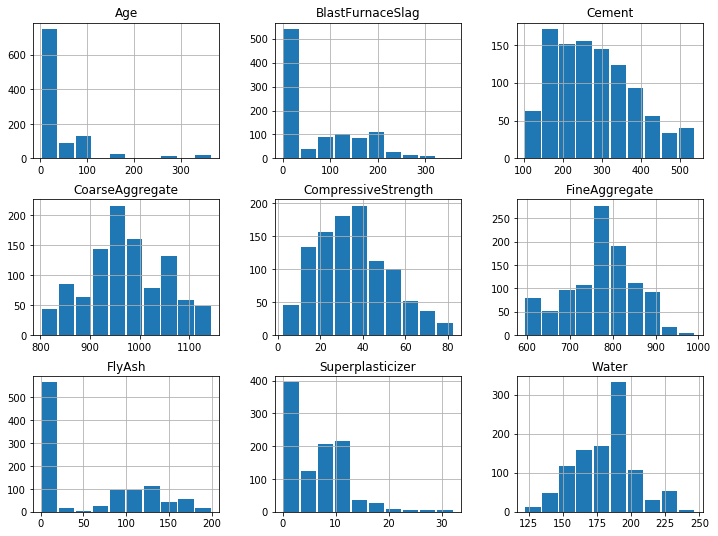

In [20]:
_ = concrete.hist(figsize=(12, 9), rwidth=.9)

In [18]:
mixtures.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,0.119553,0.043101,0.044815,0.082058,0.115282,0.149170,0.225406
BlastFurnaceSlag,1030.0,0.031643,0.036961,0.000000,0.000000,0.009455,0.061972,0.150339
FlyAsh,1030.0,0.023174,0.027462,0.000000,0.000000,0.000000,0.050335,0.088838
Water,1030.0,0.077727,0.010900,0.051390,0.069538,0.078623,0.083861,0.112222
Superplasticizer,1030.0,0.002621,0.002495,0.000000,0.000000,0.002727,0.004351,0.013149
CoarseAggregate,1030.0,0.415165,0.031020,0.345890,0.392294,0.420464,0.437598,0.479846
FineAggregate,1030.0,0.330117,0.033244,0.247971,0.311208,0.330542,0.354096,0.414147
Age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
CompressiveStrength,1030.0,35.817961,16.705742,2.330000,23.710000,34.445000,46.135000,82.600000


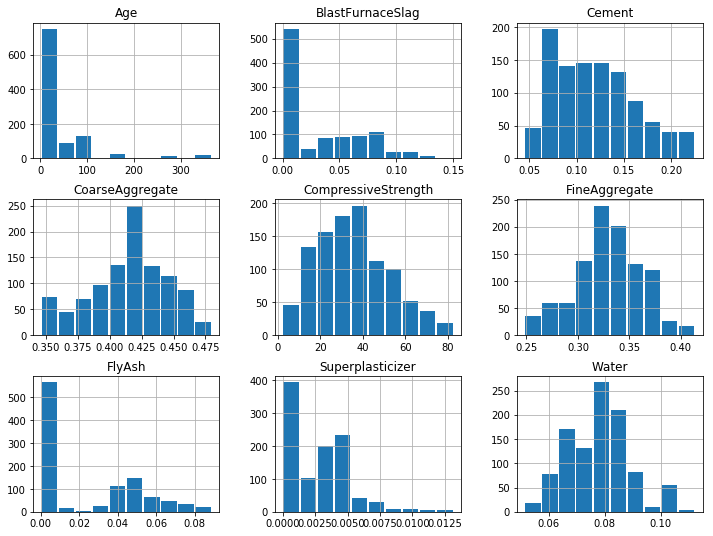

In [22]:
_ = mixtures.hist(rwidth=.9, figsize=(12, 9))

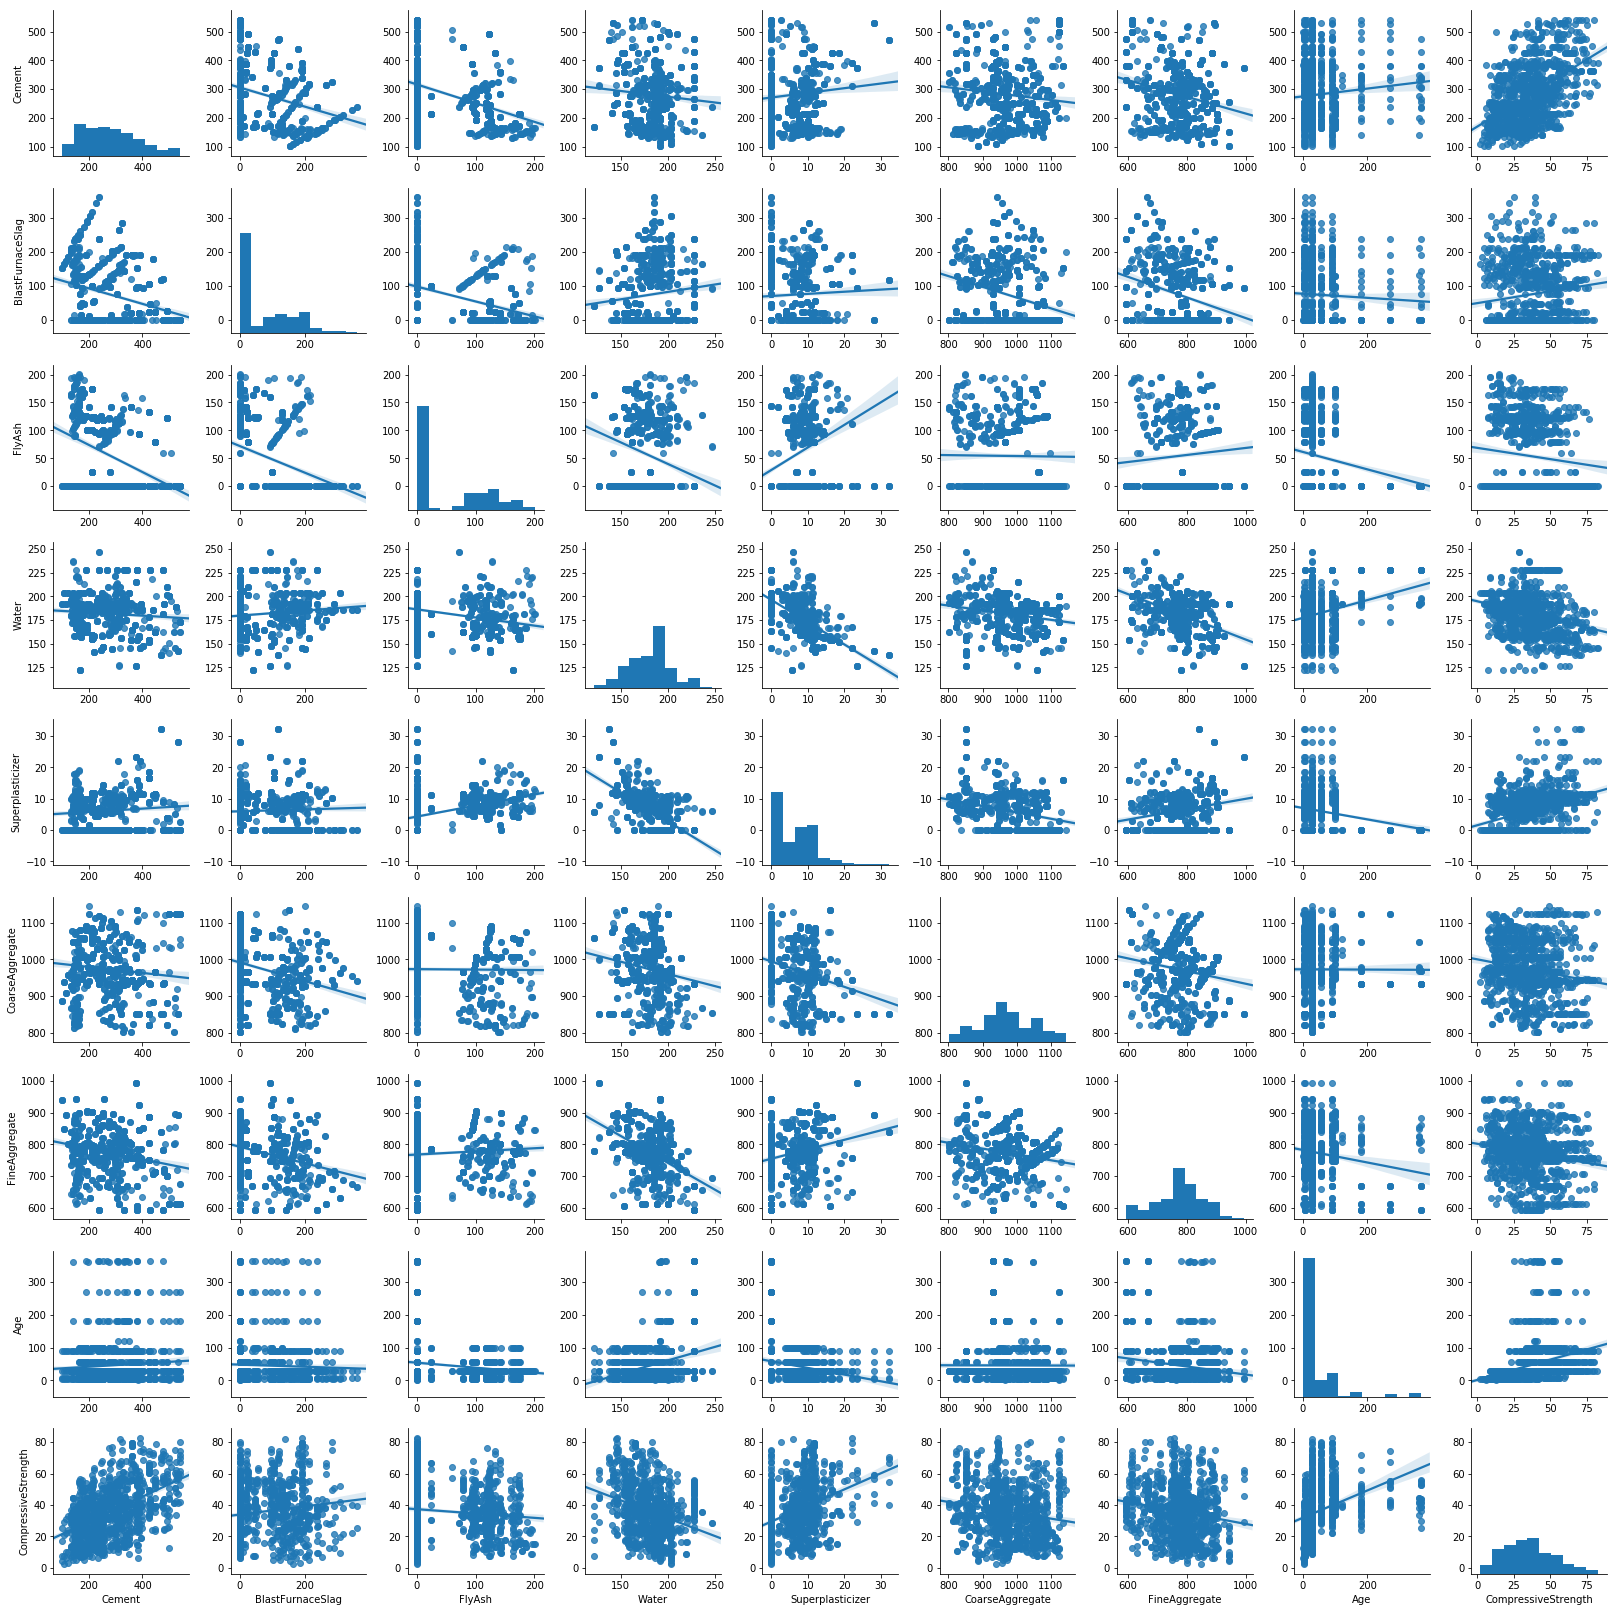

In [30]:
sns.pairplot(concrete, kind='reg')

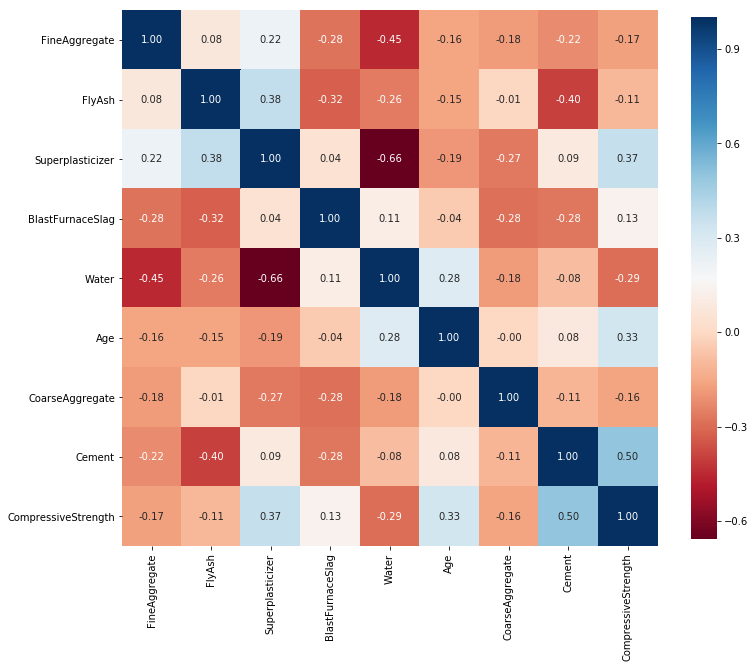

In [29]:
corr = concrete.corr()

Y = linkage(corr, method='complete', metric='correlation')
Z = dendrogram(Y, no_plot=True)['leaves']

corr = corr.iloc[:, Z]
corr = corr.iloc[Z, :]

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, square=True, annot=True, fmt='.2f', ax=ax,
            xticklabels=True, yticklabels=True, cmap=plt.cm.RdBu, cbar_kws={"shrink":.8})

In [32]:
concrete.iloc[:, :-1].shape

(1030, 8)

In [33]:
concrete.iloc[:, :-1].drop_duplicates().shape

(992, 8)

In [40]:
# combine duplicate formulas
concrete_avg = concrete.groupby(list(concrete.columns[:-1]), as_index=False)['CompressiveStrength'].mean()

In [41]:
concrete_avg.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3,4.57
1,102.0,153.0,0.0,192.0,0.0,887.0,942.0,7,7.68
2,102.0,153.0,0.0,192.0,0.0,887.0,942.0,28,17.28
3,102.0,153.0,0.0,192.0,0.0,887.0,942.0,90,25.46
4,108.3,162.4,0.0,203.5,0.0,938.2,849.0,3,2.33


### dataset: Train / Val / Test 

In [43]:
X = concrete_avg.iloc[:, :-1]
y = concrete_avg['CompressiveStrength']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
X_train.shape, X_test.shape

((744, 8), (248, 8))

In [45]:
k10 = KFold(n_splits=10, shuffle=True, random_state=123)

In [124]:
def plot_regression(clf, X, y, title=''):
    y_pred = clf.predict(X)
    err = y_pred - y

    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

    ax[0].scatter(y, y_pred, alpha=.5)
    ax[0].plot(y, y, 'k--')
    ax[0].set(xlabel='actual', ylabel='predict')
    ax[1].scatter(y_pred, err, alpha=.5)
    ax[1].axhline(0, linestyle='--', color='k')
    ax[1].set(xlabel='predict', ylabel='residuals')
    if title:
        fig.suptitle("{}:\nR2={:.4f}, RMSE:{:.4f}".format(title, 
                                                          clf.score(X, y), 
                                                         np.sqrt(mean_squared_error(y, y_pred))))
    

### Linear Regression

In [81]:
lr_clf = make_pipeline(PolynomialFeatures(include_bias=False), 
                       #StandardScaler(), 
                       LinearRegression())
scores = cross_val_score(lr_clf, 
                         X_train, y_train, cv=k10, scoring='r2')

In [82]:
scores.mean(), scores.std()

(0.76281584199952168, 0.06468909003413234)

In [83]:
lr_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

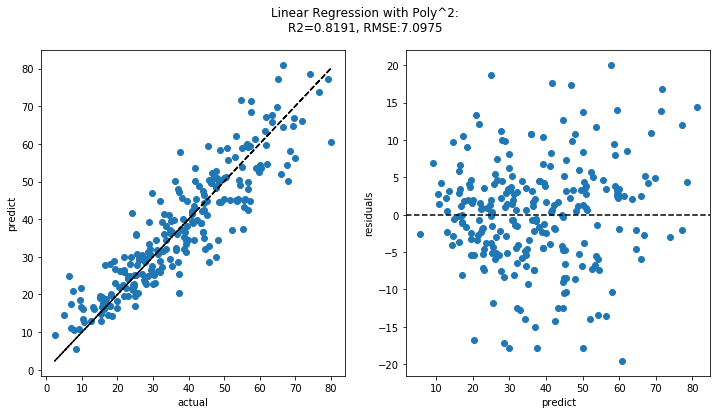

In [87]:
plot_regression(lr_clf, X_test, y_test, 'Linear Regression with Poly^2')

### ElasticNet

In [77]:
elas_reg = make_pipeline(PolynomialFeatures(include_bias=False), StandardScaler(), ElasticNet(max_iter=5000))

elas_params = {'elasticnet__alpha': [.01, .05, .1, .5, 1], 
               'elasticnet__l1_ratio': [.1, .3, .5, .7, .9]}

elas_grid = GridSearchCV(elas_reg, elas_params, cv=k10, scoring='r2')
elas_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=5000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'elasticnet__alpha': [0.01, 0.05, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [79]:
elas_grid.best_score_, elas_grid.best_params_

(0.74478443763482405, {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.5})

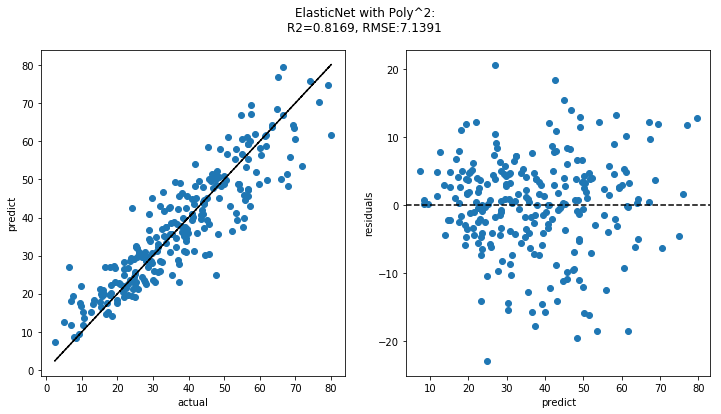

In [88]:
plot_regression(elas_grid, X_test, y_test, 'ElasticNet with Poly^2')

### SVR

In [95]:
svr = make_pipeline(StandardScaler(), SVR())
svr_params = {'svr__C': [100, 200, 400], 'svr__gamma': ['auto']}

svr_grid = GridSearchCV(svr, svr_params, cv=k10, scoring='r2', verbose=1)
svr_grid.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    8.4s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__C': [100, 200, 400], 'svr__gamma': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [96]:
svr_grid.best_params_, svr_grid.best_score_

({'svr__C': 200, 'svr__gamma': 'auto'}, 0.84809906589040174)

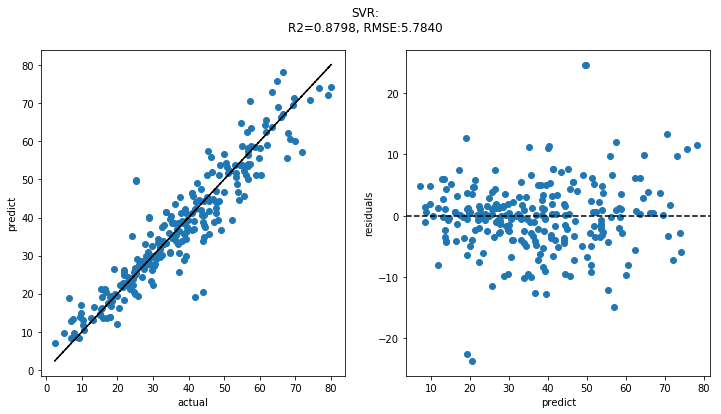

In [97]:
plot_regression(svr_grid, X_test, y_test, 'SVR')

### DecisionTree

In [100]:
tree_reg = DecisionTreeRegressor()
tree_params = {'criterion': ['mae', 'mse'], 
               'max_depth': [8, 9, 10, 11], 
               'min_samples_split': [8, 10, 20]}

tree_grid = GridSearchCV(tree_reg, tree_params, cv=k10, scoring='r2', verbose=1)
tree_grid.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    5.0s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [8, 10, 20], 'criterion': ['mae', 'mse'], 'max_depth': [8, 9, 10, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [101]:
tree_grid.best_params_, tree_grid.best_score_

({'criterion': 'mse', 'max_depth': 10, 'min_samples_split': 10},
 0.79107277144144994)

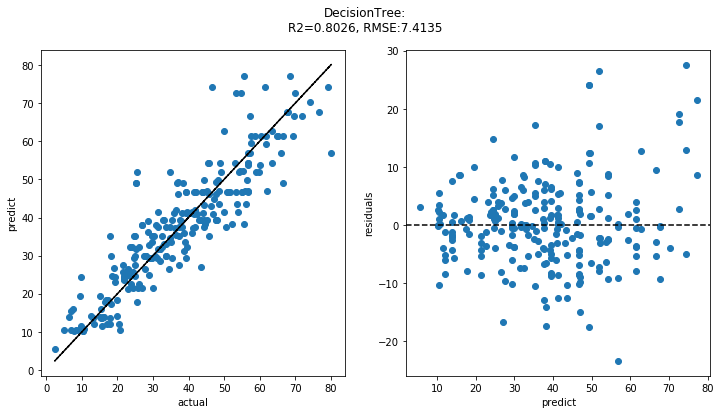

In [102]:
plot_regression(tree_grid, X_test, y_test, 'DecisionTree')

### RandomForest

In [103]:
rf_reg = RandomForestRegressor()
rf_params = {'n_estimators': [10, 20, 50, 100], 
             'max_depth': [None, 7, 9 , 11], 
             'min_samples_split': [2, 10, 20, 30]}

rf_grid = GridSearchCV(rf_reg, rf_params, cv=k10, scoring='r2', verbose=1)
rf_grid.fit(X_train, y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:  1.4min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 10, 20, 30], 'n_estimators': [10, 20, 50, 100], 'max_depth': [None, 7, 9, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [104]:
rf_grid.best_params_, rf_grid.best_score_

({'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50},
 0.88578222283478636)

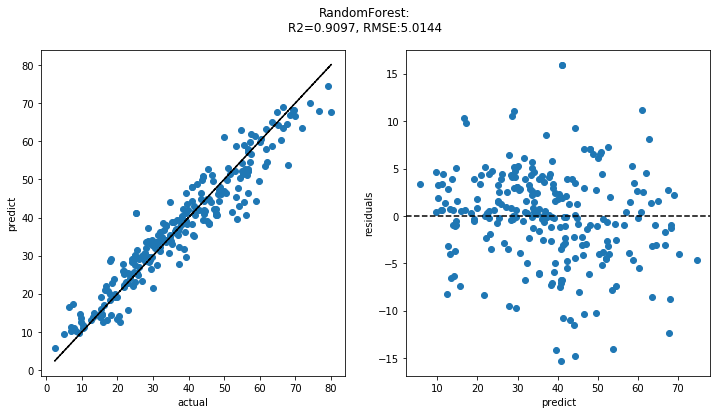

In [105]:
plot_regression(rf_grid, X_test, y_test, 'RandomForest')

### LightGBM

In [121]:
lgbm_params = {'n_estimators': [400], 'learning_rate': [.075, ], "subsample": [.8, ]}

lgbm_grid = GridSearchCV(LGBMRegressor(), lgbm_params, cv=k10, scoring='r2', verbose=1)
lgbm_grid.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/home/pongsakorn/anaco

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
       max_bin=255, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.8], 'n_estimators': [400], 'learning_rate': [0.075]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [122]:
lgbm_grid.best_params_, lgbm_grid.best_score_

({'learning_rate': 0.075, 'n_estimators': 400, 'subsample': 0.8},
 0.92602134133739522)

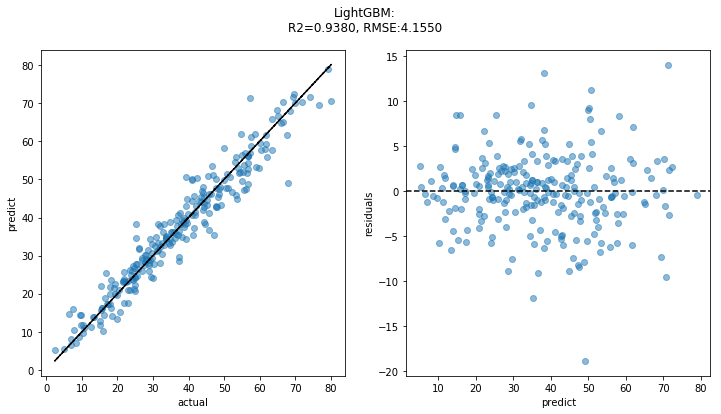

In [125]:
plot_regression(lgbm_grid, X_test, y_test, 'LightGBM')

In [126]:
g = concrete_avg.groupby('Age')

In [131]:
g.get_group(28).sort_values(by='CompressiveStrength', ascending=False).head()

,BlastFurnaceSlag,Cement,CoarseAggregate,CompressiveStrength,FineAggregate,FlyAsh,Superplasticizer,Water
673,137.0,315.0,1130.0,81.75,745.0,0.0,5.9,145.0
983,0.0,540.0,1040.0,79.99,676.0,0.0,2.5,162.0
917,0.0,451.0,1030.0,78.80,745.0,0.0,11.3,165.0
518,180.0,275.0,830.0,76.24,765.0,120.0,10.4,162.0
969,0.0,522.0,896.0,74.99,896.0,0.0,0.0,146.0
